# Test Notebook for solvers Algorithms

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

# Operator imports
import ndoperators as ops
import llops as yp

# Libwallerlab imports
from ndoperators import solvers
from ndoperators.solvers import objectivefunctions, regularizers
import libwallerlab.utilities.simulation as sim

('libforge.1.dylib', '/opt/arrayfire/lib/libforge.1.dylib')


In [3]:
ops.setDefaultBackend('arrayfire') # arrayfire or numpy
ops.setDefaultDatatype('complex32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Generate Forward Model For Convolutional System with Windowing

<IPython.core.display.Javascript object>


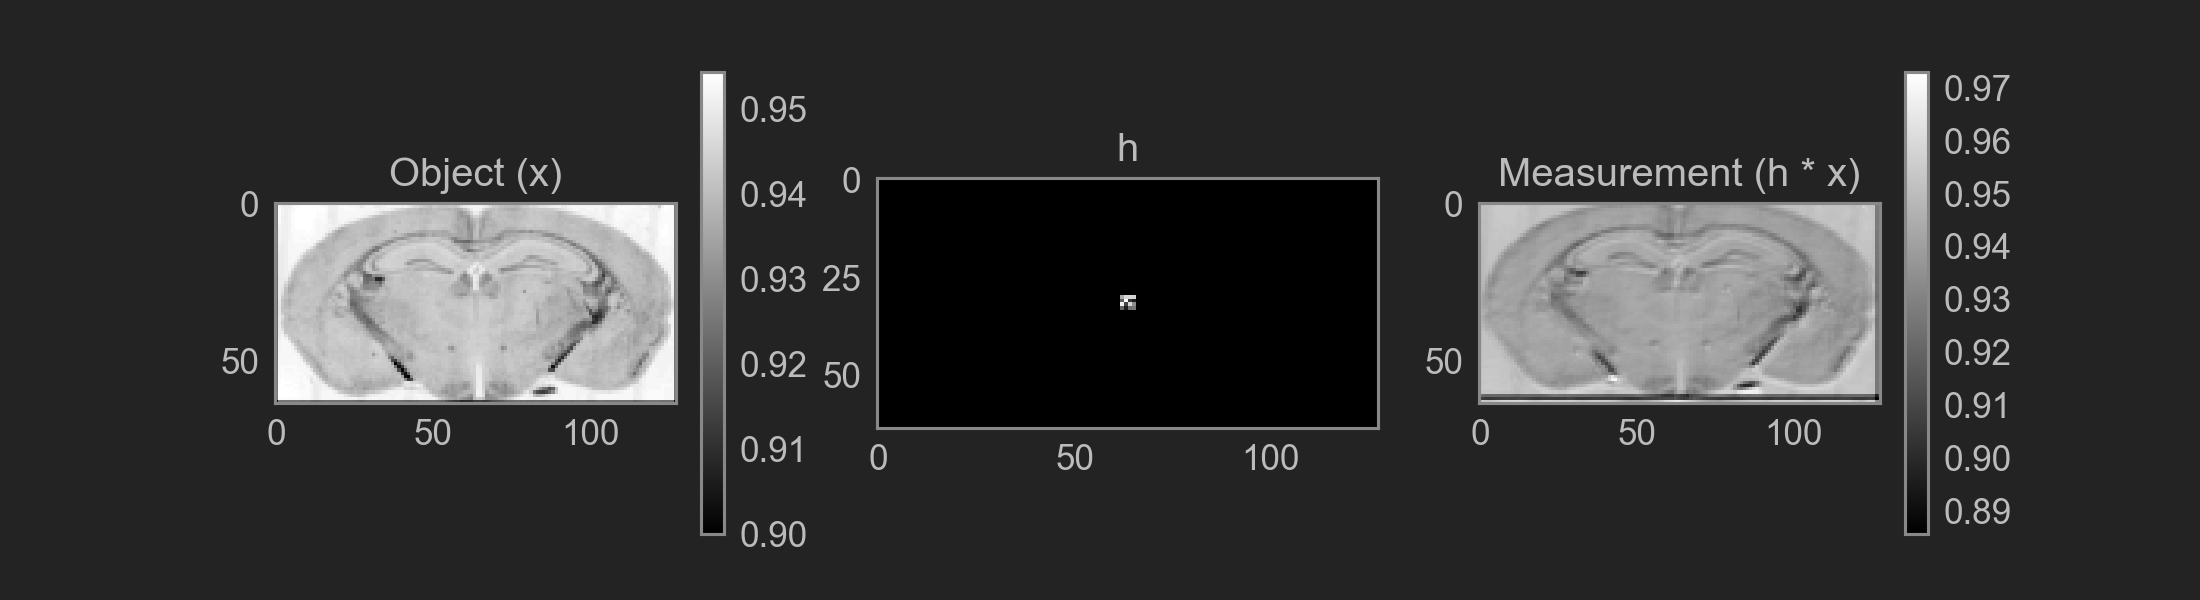

In [4]:
# Image size to simulate
image_size = np.array([32, 64]) * 2

# Create test object
brain = sim.testObject('brain', image_size, color_channel=2, dtype=global_dtype)
object_true = yp.changeBackend(brain, global_backend)

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.sumb(h)

A = ops.Convolution(h, mode='circular')
y = A * object_true

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(np.asarray(h)), cmap='gray')
plt.title('h')
plt.subplot(133)
plt.imshow((np.abs(np.asarray(y))).reshape(image_size), cmap='gray')
plt.title('Measurement (h * x)');
plt.colorbar()

# Reconstructions

## L2 Objective

In [5]:
# Generate Objective
objective = objectivefunctions.L2(A, y)

# Generate Object
x = yp.ones(objective.N, global_dtype, global_backend)

# Render latex
objective.latex()

<IPython.core.display.Latex object>

### Gradient Descent

<IPython.core.display.Javascript object>


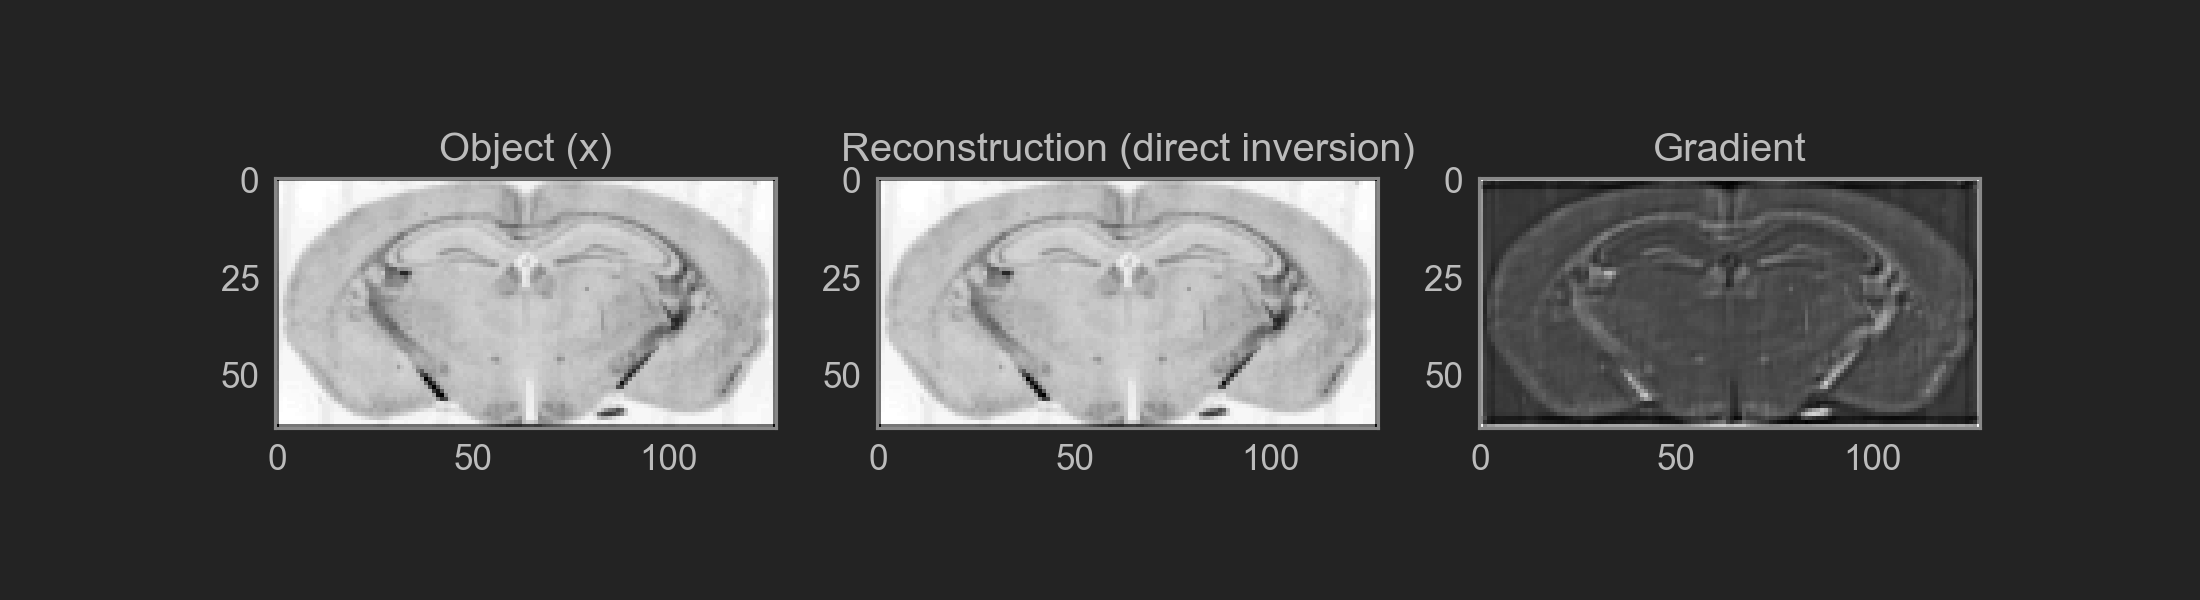

In [6]:
# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.subplot(132)
plt.imshow(np.abs(A.inv * y), cmap='gray')
plt.title('Reconstruction (direct inversion)')
plt.subplot(133)
plt.imshow(yp.abs(objective.gradient(x)), cmap='gray')
plt.title('Gradient');

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ------------------------ +
|    0   |    3.62e+03    |       0.00       |    0.00e+00    |  289.7 MB /    0.9 MB  |
|   50   |    3.81e-05    |       1.42       |    3.51e-04    |  289.7 MB /    1.8 MB  |
|  100   |    3.95e-06    |       2.30       |    2.29e-05    |  289.7 MB /    1.8 MB  |
|  150   |    5.33e-07    |       3.15       |    7.63e-06    |  289.7 MB /    1.8 MB  |
|  200   |    7.32e-08    |       3.99       |    7.63e-06    |  289.7 MB /    1.7 MB  |
|  250   |    2.43e-08    |       4.85       |    1.53e-05    |  289.7 MB /    1.7 MB  |
|  300   |    2.15e-08    |       5.71       |    0.00e+00    |  289.7 MB /    1.6 MB  |
|  350   |    2.02e-08    |       6.62       |    0.00e+00    |  289.7 MB /    1.6 MB  |
|  400   |    1.91e-08    |       7.52       |    0.00e+00    |  289.8 MB /    2.0 MB  |
|  450   |    1.82e

<IPython.core.display.Javascript object>


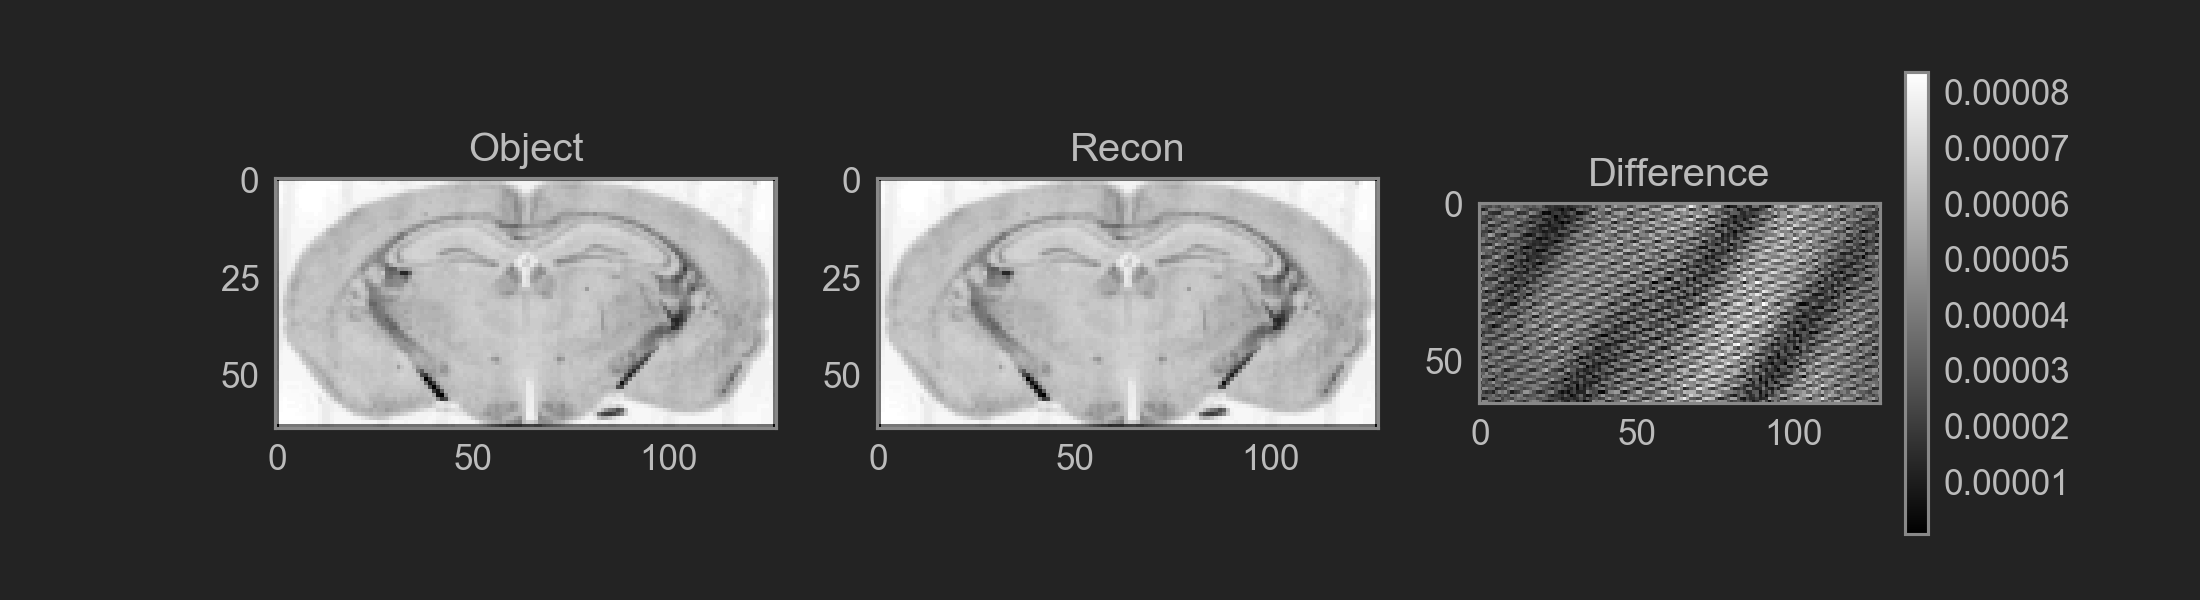

In [14]:
# Minimize objective using Gradient Descent
x_opt = solvers.GradientDescent(objective).solve(iteration_count=500, display_type='text', step_size=0.1, display_iteration_delta=50, 
                                                   use_nesterov_acceleration=True, nesterov_restart_enabled=True)
# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')
plt.colorbar()

## Conjugate Gradient

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ------------------------ +
|    0   |    3.62e+03    |       0.00       |    0.00e+00    |  263.3 MB /    1.9 MB  |
|    1   |    3.62e+03    |       0.01       |    0.00e+00    |  263.3 MB /    2.0 MB  |
|    2   |    2.79e+00    |       0.06       |    8.52e+01    |  263.3 MB /    2.0 MB  |
|    3   |    5.87e+00    |       0.11       |    3.18e-02    |  263.4 MB /    2.1 MB  |
|    4   |    1.48e+02    |       0.13       |    2.39e-01    |  263.5 MB /    2.2 MB  |
|    5   |    1.23e+03    |       0.17       |    2.61e+00    |  263.6 MB /    2.2 MB  |
|    6   |    5.38e+03    |       0.19       |    1.01e+01    |  263.7 MB /    2.3 MB  |
|    7   |    1.67e+04    |       0.22       |    2.38e+01    |  263.9 MB /    2.3 MB  |
|    8   |    4.16e+04    |       0.23       |    4.11e+01    |  264.0 MB /    2.4 MB  |
|    9   |    8.96e

<IPython.core.display.Javascript object>


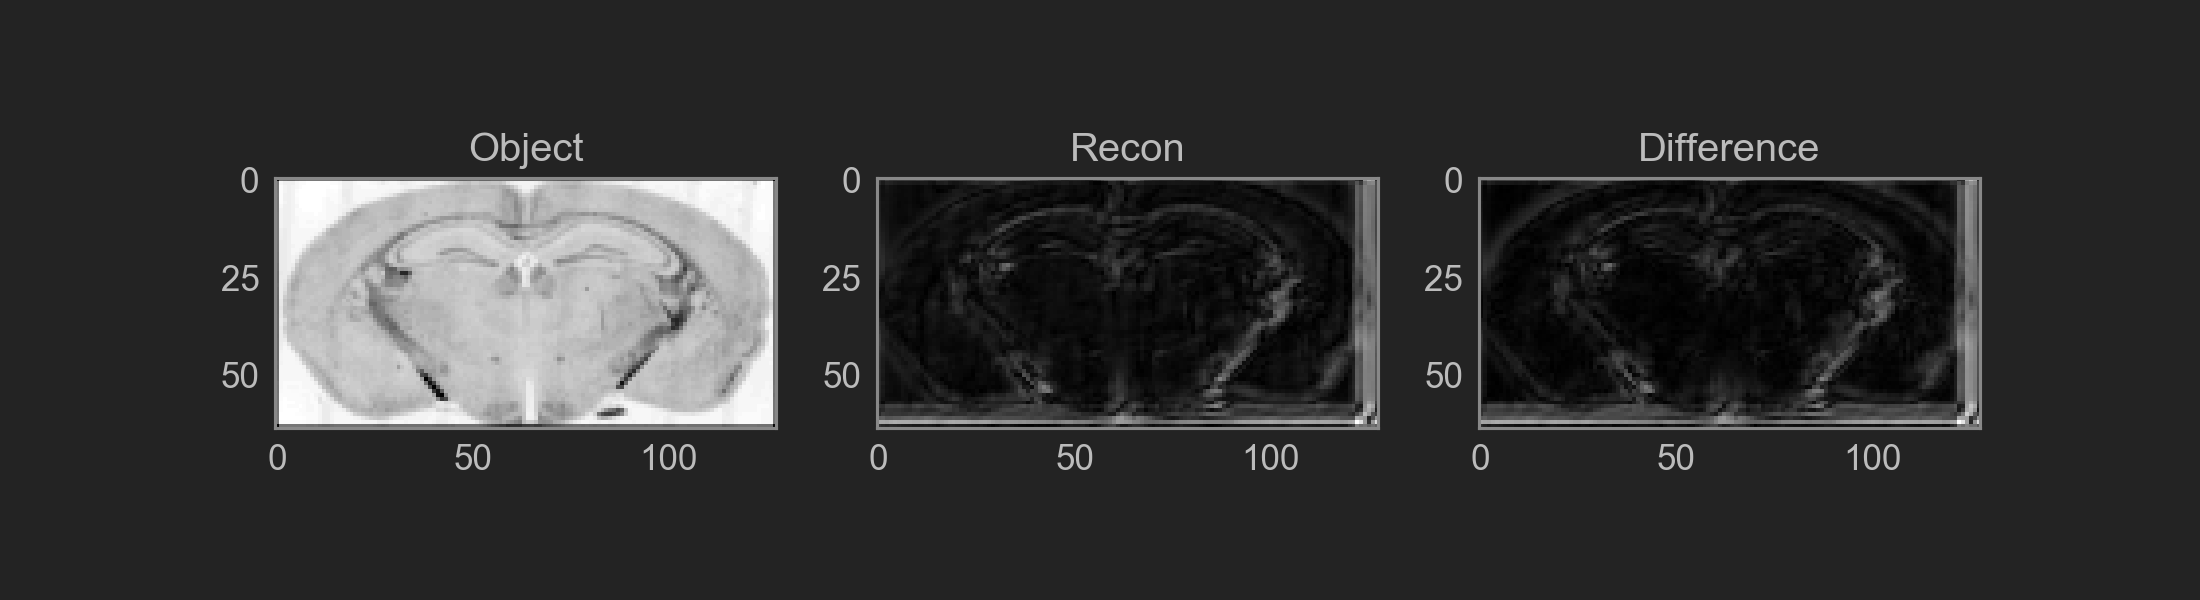

Text(0.5,1,'Difference')

In [12]:
x_opt = solvers.ConjugateGradient(A, y).solve(iteration_count=10, display_type='text', step_size=0.1, display_iteration_delta=1)

# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')

# ISTA/FISTA

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ------------------------ +
|    0   |    3.62e+03    |       0.00       |    0.00e+00    |  288.4 MB /    2.0 MB  |
|   50   |    1.33e+03    |       1.44       |    5.20e-01    |  288.6 MB /    2.2 MB  |
|  100   |    4.92e+02    |       2.30       |    3.15e-01    |  288.7 MB /    3.0 MB  |
|  150   |    1.86e+02    |       3.10       |    1.90e-01    |  288.7 MB /    2.8 MB  |
|  200   |    7.38e+01    |       3.91       |    1.15e-01    |  288.7 MB /    2.8 MB  |
|  250   |    3.30e+01    |       4.72       |    6.97e-02    |  288.7 MB /    2.8 MB  |
|  300   |    1.82e+01    |       5.53       |    4.22e-02    |  288.7 MB /    2.7 MB  |
|  350   |    1.28e+01    |       6.34       |    2.55e-02    |  288.7 MB /    2.7 MB  |
|  400   |    1.09e+01    |       7.15       |    1.54e-02    |  288.7 MB /    2.6 MB  |
|  450   |    1.03e

<IPython.core.display.Javascript object>


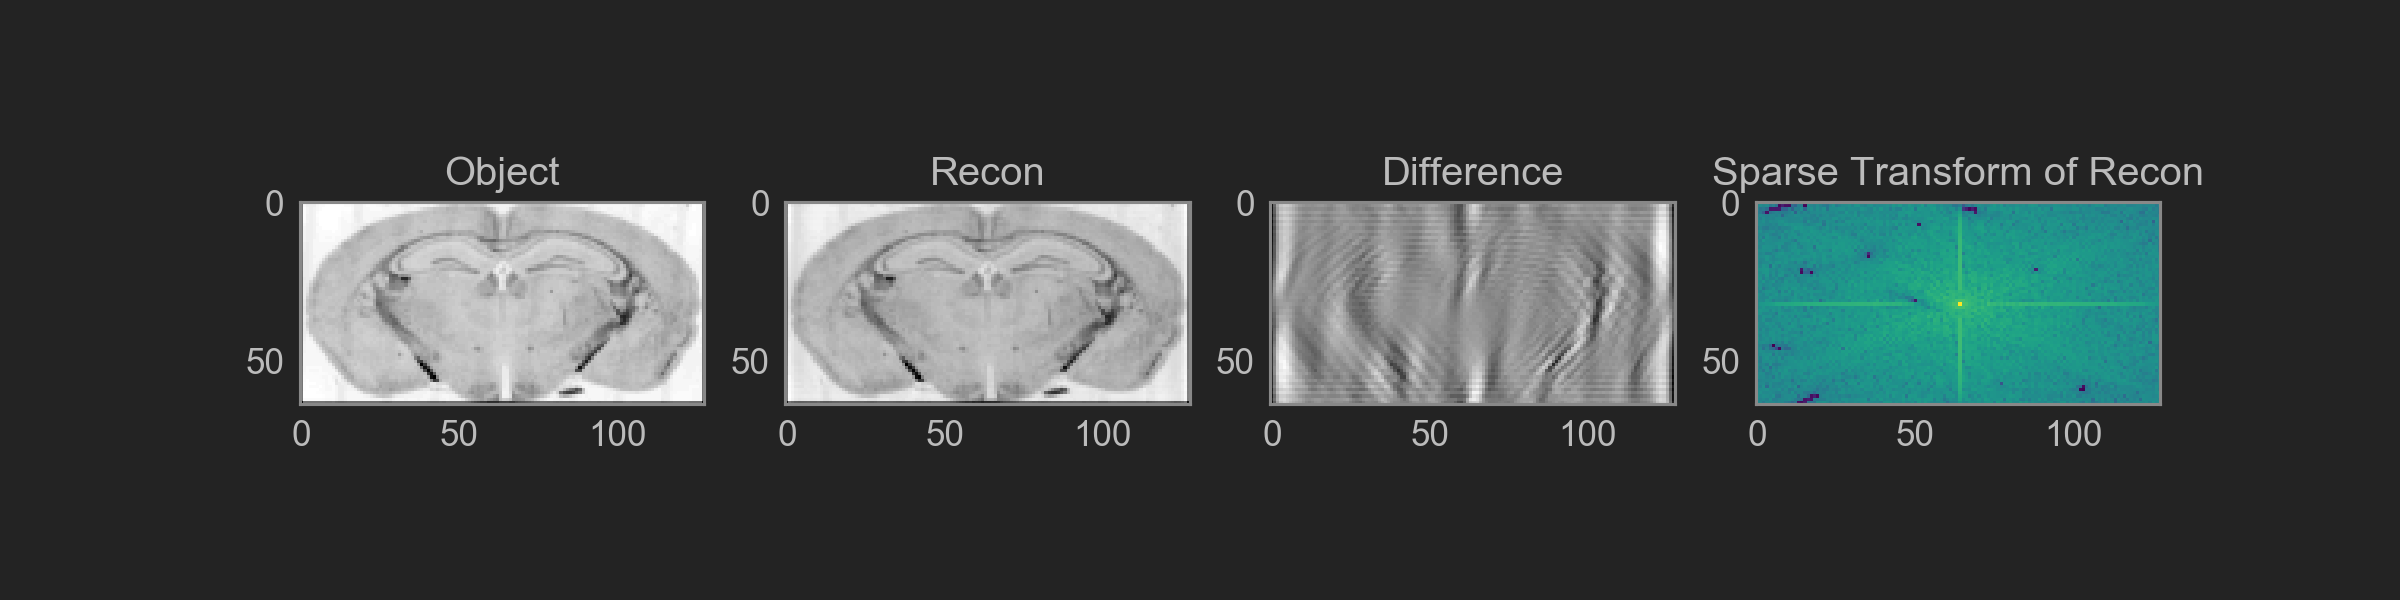

In [13]:
# Define regularizer function
reg_type = 'fourier'
if reg_type is 'wavelet':
    reg = regularizers.WaveletSparsity(image_size, wavelet_type='haar')
    sparse_op = reg.sparse_op
elif reg_type is 'fourier':
    sparse_op = ops.FourierTransform(image_size)
    reg = ops.L1Norm(image_size) * sparse_op

# Generate objective function
objective_reg = objective + 1e-3 * reg

# Solve using FISTA/ISTA
x_opt = solvers.Fista(objective_reg).solve(iteration_count=500, display_type='text', step_size=1e-2, display_iteration_delta=50, 
                                            normalize_step_size=True, use_nesterov_acceleration=False, nesterov_restart_enabled=False, let_diverge=True)

# Show object and psf
plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(142)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(143)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')
plt.subplot(144)
x_s = yp.changeBackend(sparse_op * x_opt, 'numpy')
x_s *= np.abs(x_s) > 1e-7
plt.imshow(np.log(np.abs(x_s).reshape(sparse_op.M)))
plt.title('Sparse Transform of Recon');